In [1]:
import albumentations as A
from pathlib import Path
import pandas as pd
import cv2
from tqdm import tqdm
import random
import json
import matplotlib.pyplot as plt

### Aptos-2019 Blindness Detection Dataset 
* The main files are
    * train.csv 
        * id_code : The name of the image without extension
        * diagnosis : Integer from 0 to 4
    * train_images : directory containing the images
* The test files are not useful as they do not have labels
* All the images are of png format

Stage 0 : 1805 images
Stage 1 : 370 images
Stage 2 : 999 images
Stage 3 : 193 images
Stage 4 : 295 images


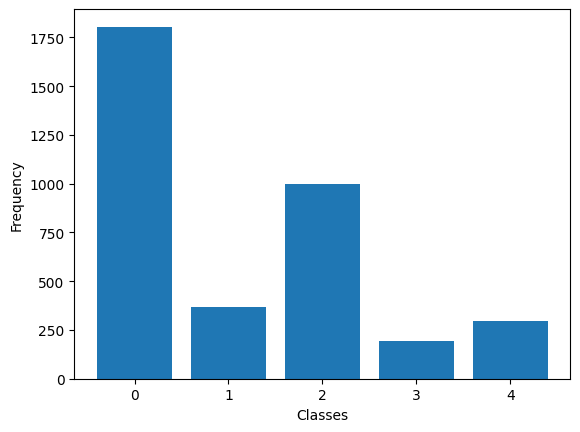

In [2]:
# Setting Up Paths
with open("../config.json") as file:
    config = json.load(file)
    aptos2019_path = Path(config["dataset"]["aptos_2019"]["original"])
    aptos2019_balanced_resized_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])

aptos_train_csv = pd.read_csv(aptos2019_path / "train.csv")
aptos_train_images = aptos2019_path / "train_images"

# Class distribution in the dataset
class_distribution = dict()
for image_class in range(0,5):
    class_distribution[image_class] = len(aptos_train_csv[aptos_train_csv["diagnosis"] == image_class])
    print(f"Stage {image_class} : {class_distribution[image_class]} images")

# Visualizing Distribution
plt.bar(
    x = [x for x in class_distribution],
    height = [class_distribution[x] for x in class_distribution]
)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show() 

#### Common Function

In [5]:
# Common Function to preprocess the Aptos2019 Dataset
def preprocess_dataset(new_path, preprocess_fn):
    new_image_path = new_path / "images"
    new_image_path.mkdir(parents = True)
    new_csv_path = new_path / "labels.csv"
    csv_data_list = []
    
    for i in tqdm(range(len(aptos_train_csv))):
        image_name = aptos_train_csv.iloc[i]["id_code"]
        image_class = aptos_train_csv.iloc[i]["diagnosis"] 
        image_path = aptos_train_images / f"{image_name}.png"
        image_file = cv2.imread(image_path)
        
        processed_images = preprocess_fn(image_file,image_class)
        for processing in processed_images:
            new_image_name = f"{image_name}_{processing}" 
            curr_processed_image_path = new_image_path / f"{new_image_name}.png"
            csv_data_list.append({"img_name":new_image_name,"class":image_class})
            cv2.imwrite(curr_processed_image_path,processed_images[processing])
            
    # Write the labels to csv
    csv_data = pd.DataFrame(csv_data_list) 
    csv_data.to_csv(new_csv_path,index=False)

### Balanced and Resized Dataset 

In [6]:
augments_needed = dict()

max_images = 3600
for image_class in range(0,5):
    num_images_in_class = len(aptos_train_csv[aptos_train_csv["diagnosis"] == image_class])
    augments_needed[image_class] = round((max_images/num_images_in_class)) - 1
    print(f"Stage {image_class} : need {augments_needed[image_class]} augmentation for each image")

Stage 0 : need 1 augmentation for each image
Stage 1 : need 9 augmentation for each image
Stage 2 : need 3 augmentation for each image
Stage 3 : need 18 augmentation for each image
Stage 4 : need 11 augmentation for each image


In [8]:
albumentation_pipeline_1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(border_mode=cv2.BORDER_CONSTANT,p=0.7),
    A.RandomCropFromBorders(p=0.4),
    A.RandomBrightnessContrast(brightness_limit=(-0.05,0.1),contrast_limit=(-0.05,0.5),p=0.3),
    A.Resize(224,224,p=1)
])

def process_balance_resize_augment(image_file, image_class):
    image_file = cv2.resize(image_file,(224,224))
    processed_images = dict()
    num_augments = augments_needed[image_class]
    processed_images["org"] = image_file
    for i in range(num_augments):
        processed_images[str(i)] = albumentation_pipeline_1(image=image_file)["image"]
    return processed_images

In [ ]:
preprocess_dataset(aptos2019_balanced_resized_path, process_balance_resize_augment)

 19%|█████████████████████████                                                                                                        | 711/3662 [02:48<09:55,  4.96it/s]